### Azure Machine Learning Service Framework

#### Set up Development Environment

Initialize Workspace
- Import base Azure ML packages
- Check the SDK version
- Connect to the workspace

#### Set up: Initialize the Workspace

In [1]:
# base packages to work with AMLS
import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Ready to use Azure ML", azureml.core.VERSION)

Ready to use Azure ML 1.18.0


In [3]:
SUBSCRIPTION_ID='79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5' # provide your subscription ID
RESOURCE_GROUP_NAME  = 'unive-resource-group' # provide a resource group name
WORKSPACE_NAME  = 'unive-workspace' # provide a name for your workspace
REGION = 'westeurope' # For example: 'westeurope' or 'eastus2' or 'westus2' or 'southeastasia'.

ws = None
try:
    # Find existing workspace
    ws = Workspace(workspace_name=WORKSPACE_NAME,
                   subscription_id=SUBSCRIPTION_ID,
                   resource_group= RESOURCE_GROUP_NAME)
    print (ws.name, "found.")
except Exception as ex:
    # If workspace not found, create it
    print(ex.message)
    print("Attempting to create new workspace...")
    ws = Workspace.create(name=WORKSPACE_NAME, 
                          subscription_id=SUBSCRIPTION_ID,
                          resource_group=RESOURCE_GROUP_NAME,
                          create_resource_group=True,
                          location=REGION)
    print(ws.name, "created.")
finally:
    # Save the workspace configuration for later
    if ws != None:
        # write out the workspace details to a configuration file: .azureml/config.json
        ws.write_config(path='.azureml')
        print(ws.name, "saved.")

get_workspace error using subscription_id=79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5, resource_group_name=unive-resource-group, workspace_name=unive-workspace


Workspace not found.
Attempting to create new workspace...


Deploying AppInsights with name univeworinsights1cdcf173.
Deployed AppInsights with name univeworinsights1cdcf173. Took 4.67 seconds.
Deploying KeyVault with name univeworkeyvaultf60f1568.
Deploying StorageAccount with name univeworstorageb28ff1cef.
Deployed KeyVault with name univeworkeyvaultf60f1568. Took 19.77 seconds.
Deploying Workspace with name unive-workspace.
Deployed StorageAccount with name univeworstorageb28ff1cef. Took 115.02 seconds.
Deployed Workspace with name unive-workspace. Took 36.01 seconds.
unive-workspace created.
unive-workspace saved.


In [2]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, ws.location, sep='\t')

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code CF67BPK8W to authenticate.
You have logged in. Now let us find all the subscriptions to which you have access...
Interactive authentication successfully completed.
unive-workspace	westeurope	unive-resource-group	westeurope


#### Set up: create compute

In [3]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

ws = Workspace.from_config() # This automatically looks for a directory .azureml
CPU_CLUSTER_NAME = "cpu-cluster" # Choose a name for your CPU cluster

# Verify that the cluster does not exist already
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=CPU_CLUSTER_NAME)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_D1_v2',
                                                            max_nodes=2, #will autoscale between zero and two nodes
                                                            idle_seconds_before_scaledown=30)
    cpu_cluster = ComputeTarget.create(ws, CPU_CLUSTER_NAME, compute_config)

cpu_cluster.wait_for_completion(show_output=True)
# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())

Creating
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


#### Set up: upload data to datastore

In [4]:
# Get the default datastore
default_ds = ws.get_default_datastore()

# Enumerate all datastores, indicating which is the default
for ds_name in ws.datastores:
    print(ds_name, "- Default =", ds_name == default_ds.name) # workspaceblobstore <- Default

# Adult Census Income Binary classfication dataset
default_ds.upload_files(files=['./data/iris_transformed.csv'], # Upload the data/adults.csv file
                       target_path='iris-data/', # Put it in a folder path in the datastore
                       overwrite=True, # Replace existing files of the same name
                       show_progress=True)

azureml_globaldatasets - Default = False
workspacefilestore - Default = False
workspaceblobstore - Default = True
Uploading an estimated of 1 files
Uploading ./data/iris_transformed.csv
Uploaded ./data/iris_transformed.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_552c82434e8c4a05b7faf651580bca0f

#### Initialize an Experiment

In [33]:
# Name your experiment here.
experiment_name = 'train_iris_svc'

from azureml.core import Experiment
experiment = Experiment(workspace=ws, name=experiment_name)
print(f"Experiment: {experiment.name}")

Experiment: train_iris_svc


In [50]:
# Directory to write training script.
# Code Directory
import os
script_folder = os.path.join(os.getcwd(), "script")
os.makedirs(script_folder, exist_ok=True)

hello


#### Dataset

This is also the folder where we’ll want to write out any file outputs (training, scoring, YAML,etc.)

In [7]:
from azureml.core import Dataset

ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)

#Create a tabular dataset from the path on the datastore (this may take a short while)
data_set = Dataset.Tabular.from_delimited_files(path=(ds, 'iris-data/iris_transformed.csv'))

# Display the first 20 rows as a Pandas dataframe
data_set.take(4).to_pandas_dataframe()

AzureBlob univeworstorageb28ff1cef azureml-blobstore-61e6cee9-37bf-4546-bd2a-9e4d5ced1d79


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0


In [35]:
# Register the dataset
dataset_name = 'Dataset-iris'
data_set = data_set.register(workspace=ws, 
                           name=dataset_name,
                           description='The Iris dataset was used in R.A. Fisher\'s classic 1936 paper',
                           tags = {'classes':'(Setosa, Versicolour, and Virginica)', 'rows':'150'},
                           create_new_version=True)

# List the datasets registered in the workspace
for ds in ws.datasets:
    print(ds)

Dataset-iris


#### Setup: Create an environment

In [36]:
%%writefile conda_dependencies.yml

dependencies:
- python=3.8.3
- scikit-learn
- pandas
- matplotlib
- lightgbm
- pip:
  - azureml-defaults

Overwriting conda_dependencies.yml


In [37]:
from azureml.core import Environment

sklearn_env = Environment.from_conda_specification(name = 'sklearn-env', file_path = './conda_dependencies.yml')


#### Training the model

Three steps involved in training and executing an experiment in the Azure ML Service:

1. Create the Training Script

For this code to work inside of the Azure ML service, the last few lines that output the pickle file are mandatory. The pickle file is what is used to register the Model inside of the Azure ML service.

In [38]:
%%writefile $script_folder/train_iris_SVC.py
import os
import argparse
import joblib
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import warnings filter
import warnings
warnings.filterwarnings('ignore')
# ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from typing import Tuple
from sklearn.preprocessing import StandardScaler
def preprocess_standard(X_train: np.ndarray, X_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Standard scaling: Gaussian with zero mean and unit variance

    Scales `X_train` to [0, 1] , `X_test` to [0, 1]

    :param x: Data instances.
    :param y: Labels.
    :return: Rescaled values of `x`, `y`.
    """
    
    stdsc = StandardScaler()
    X_train_std = stdsc.fit_transform(X_train)
    X_test_std = stdsc.transform(X_test)
    
    return X_train_std, X_test_std

from azureml.core import Workspace, Dataset, Experiment, Run
# Get the experiment run context
run = Run.get_context()

# load the dataset
dataset_name = 'Dataset-iris'
print("Loading data from " + dataset_name)
#IRIS dataset
df = Dataset.get_by_name(workspace=run.experiment.workspace, name=dataset_name).to_pandas_dataframe()
X = df.drop('species', axis=1).values
y = df['species'].values

from sklearn.model_selection import train_test_split
#use stratify for un balanced number of examples for each class label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,shuffle=True)

print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

#(X_train, X_test) = preprocess_standard(X_train[:,[0,1]], X_test[:,[0,1]])    #  0=sepal length, 1=sepal width
(X_train, X_test) = preprocess_standard(X_train[:,2:], X_test[:,2:])           #  2=petal length, 3=petal width

# Model Training: Support Vector Machines
from sklearn.svm import SVC

model = SVC(kernel='rbf', C=0.001, random_state=42, probability=True)
model.fit(X_train, y_train)
print(f"model: {model}")

# Evaluate the model
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average='macro'):
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)
    y_pred_bin = lb.fit_transform(y_pred)
    
    return metrics.roc_auc_score(y_test_bin, y_pred_bin, average)


y_pred = model.predict(X_test)
print(f"prediction: {y_pred}")
run.log('y_pred:', y_pred)
print(f"y_true: {y_test}")
print(f'Misclassified examples:{(y_test != y_pred).sum()}')
run.log('Misclassified examples:', (y_test != y_pred).sum())

# Confusion Matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
print(f"confusion matrix:\n {conf_mat}")
run.log('confusion matrix:', conf_mat)

# Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
run.log('Accuracy:', accuracy)

# Precision
print('\n[Precision]')
precision = metrics.precision_score(y_test, y_pred, average=None)
print(f'Individual: {precision[0]:.2f}, {precision[1]:.2f}, {precision[2]:.2f}')
precision = metrics.precision_score(y_test, y_pred, average='micro')
print(f"micro: {precision}")
run.log('Precision-micro:', precision )
precision = metrics.precision_score(y_test, y_pred, average='macro')
print(f"macro: {precision}")
run.log('Precision-macro:', precision )

# Recall
print('\n[Recall]')
recall = metrics.recall_score(y_test, y_pred, average=None)
print(f'Individual: {recall[0]:.2f}, {recall[1]:.2f}, {recall[2]:.2f}')
recall = metrics.recall_score(y_test, y_pred, average='micro')
print(f"micro: {recall}")
run.log('Recall-micro:', recall)
recall = metrics.recall_score(y_test, y_pred, average='macro')
print(f"macro: {recall}")
run.log('Recall-macro:', recall)

# F1
print('\n[F1-score]')
f1 = metrics.f1_score(y_test, y_pred, average=None)
print(f'Individual: {f1[0]:.2f}, {f1[1]:.2f}, {f1[2]:.2f}')
f1 = metrics.f1_score(y_test, y_pred, average='micro')
print(f"micro: {f1}")
run.log('F1-micro:', f1)
f1 = metrics.f1_score(y_test, y_pred, average='macro')
print(f"macro: {f1}")
run.log('F1-macro:', f1)

# AUC
print('\n[ROC AUC]')
auc = multiclass_roc_auc_score(y_test, y_pred, average='macro')
print(f"macro: {auc}")
run.log('auc:', auc)

# classification_report
print(f"\nclassification_report:\n {metrics.classification_report(y_test, y_pred)}")

# Predicting classes and class probabilities
print(f"\nX_test:\n {X_test[0:5,:]}")
print(f"\nclass probabilities:\n {model.predict_proba(X_test[0:5,:])}")
print(f"\nPredicting classes: {model.predict(X_test[0:5,:])}")


# Save model
print('Exported model: iris_SVC.pkl')
f = open('iris_SVC.pkl', 'wb')
pickle.dump(model, f)
f.close()

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=model, filename='outputs/iris_SVC.pkl')


# save Graphs
# Graph 1
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
run.log_image('conf_mat', plot=plt)

Overwriting /mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-ds1v2/code/Users/877159/script/train_iris_SVC.py


2. Submit the Training Job to the Compute Cluster

When this code section completes, an Experiment will show up in the Azure portal in your Azure ML workspace resource. Also, assuming your Experiment has a pickle file output, that file is created here.

In [39]:
from azureml.core.compute import AmlCompute
from azureml.core import ScriptRunConfig
from azureml.core.runconfig import DEFAULT_CPU_IMAGE

# Create a script config
src = ScriptRunConfig(source_directory=script_folder, script='train_iris_SVC.py', environment=sklearn_env)

compute_target = None
for compute_name  in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print("found compute target: " + compute_name)
# Set compute target to the one created in previous step
src.run_config.target = compute_target
print(f"compute_target: {compute_target}")
 
run = experiment.submit(config=src)

found compute target: cpu-cluster
compute_target: AmlCompute(workspace=Workspace.create(name='unive-workspace', subscription_id='79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5', resource_group='unive-resource-group'), name=cpu-cluster, id=/subscriptions/79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5/resourceGroups/unive-resource-group/providers/Microsoft.MachineLearningServices/workspaces/unive-workspace/computes/cpu-cluster, type=AmlCompute, provisioning_state=Succeeded, location=westeurope, tags=None)


#### Monitor the run

Here we can monitor the progress of the run with a Jupyter widget. 

In [40]:
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

And we can watch the execution of the Training with the following code.


In [41]:
%%time
# specify show_output to True for a verbose log
run.wait_for_completion(show_output=True)

RunId: train_iris_svc_1606307586_b552d821
Web View: https://ml.azure.com/experiments/train_iris_svc/runs/train_iris_svc_1606307586_b552d821?wsid=/subscriptions/79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5/resourcegroups/unive-resource-group/workspaces/unive-workspace

Execution Summary
RunId: train_iris_svc_1606307586_b552d821
Web View: https://ml.azure.com/experiments/train_iris_svc/runs/train_iris_svc_1606307586_b552d821?wsid=/subscriptions/79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5/resourcegroups/unive-resource-group/workspaces/unive-workspace

CPU times: user 36.8 ms, sys: 159 µs, total: 36.9 ms
Wall time: 217 ms


{'runId': 'train_iris_svc_1606307586_b552d821',
 'target': 'cpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2020-11-25T12:40:10.888154Z',
 'endTimeUtc': '2020-11-25T12:47:57.016292Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'eb7976f8-e25f-4433-ac94-98ba470a9687',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': 'a5761cb4-6233-4916-82f5-4dea3934cf9b'}, 'consumptionDetails': {'type': 'Reference'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'train_iris_SVC.py',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'cpu-cluster',
  'dataReferences': {},
  'data': {},
  'outputData': {},
  'jobName': None,
  'maxRunDurationSeconds': 2592000,
  'nodeCount': 1,
  'priority': None,
  'environment': {'name': 'sklearn-env',
   'version': 'Aut

3. Register the Model

Registers the output pickle file in the Azure ML service workspace. Once this code completes, a Model will show up in the Azure portal.

In [42]:
# register model 
model = run.register_model(model_name='model-iris', model_path='outputs/iris_SVC.pkl')
print(model.name, model.id, model.version, sep='\t')

model-iris	model-iris:1	1


4. Download the model

In [43]:
# download model
import os 
from azureml.core import Workspace
from azureml.core.model import Model

ws = Workspace.from_config()
model=Model(ws, 'model-iris')
model.download(target_dir=os.path.join(os.getcwd(), "model"), exist_ok=True)

# verify the downloaded model file
file_path = os.path.join(os.getcwd(), "model/iris_SVC.pkl")
print(f"file path: {file_path}")
os.stat(file_path)

file path: /mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-ds1v2/code/Users/877159/model/iris_SVC.pkl


os.stat_result(st_mode=33279, st_ino=15564510680936611840, st_dev=46, st_nlink=1, st_uid=0, st_gid=0, st_size=6890, st_atime=1606308814, st_mtime=1606308814, st_ctime=1606308814)

Loading data from Dataset-iris
X_train.shape: (105, 4)
y_train.shape: (105,)
X_test.shape: (45, 4)
y_test.shape: (45,)
model: SVC(C=0.001, probability=True, random_state=42)
prediction: [1 1 2 1 1 1 1 2 1 1 2 1 1 1 1 1 2 1 1 2 1 2 1 2 2 2 2 2 1 1 1 1 1 1 1 2 1
 1 1 1 2 1 1 1 1]
y_true: [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0]
Misclassified examples:19
confusion matrix:
 [[ 0 19  0]
 [ 0 13  0]
 [ 0  0 13]]
Accuracy: 0.5777777777777777

[Precision]
Individual: 0.00, 0.41, 1.00
micro: 0.5777777777777777
macro: 0.46875

[Recall]
Individual: 0.00, 1.00, 1.00
micro: 0.5777777777777777
macro: 0.6666666666666666

[F1-score]
Individual: 0.00, 0.58, 1.00
micro: 0.5777777777777777
macro: 0.5259259259259259

[ROC AUC]
macro: 0.25

classification_report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.41      1.00      0.58        13
           2       1.00      1.00      1.00        13

    accuracy                           0.58        45
   macro avg       0.47      0.67      0.53        45
weighted avg       0.41      0.58      0.46        45


X_test:
 [[ 0.48403749 -0.05143998]
 [-1.26851205 -1.26670948]
 [ 1.76924049  1.43388941]
 [ 0.36720086  0.35364985]
 [ 0.54245581  0.21861991]]

class probabilities:
 [[0.33606237 0.34238447 0.32155316]
 [0.33077704 0.34589579 0.32332717]
 [0.3353296  0.34525419 0.31941621]
 [0.33639327 0.3425741  0.32103264]
 [0.33638159 0.34261136 0.32100704]]

Predicting classes: [1 1 2 1 1]
Exported model: iris_SVC.pkl

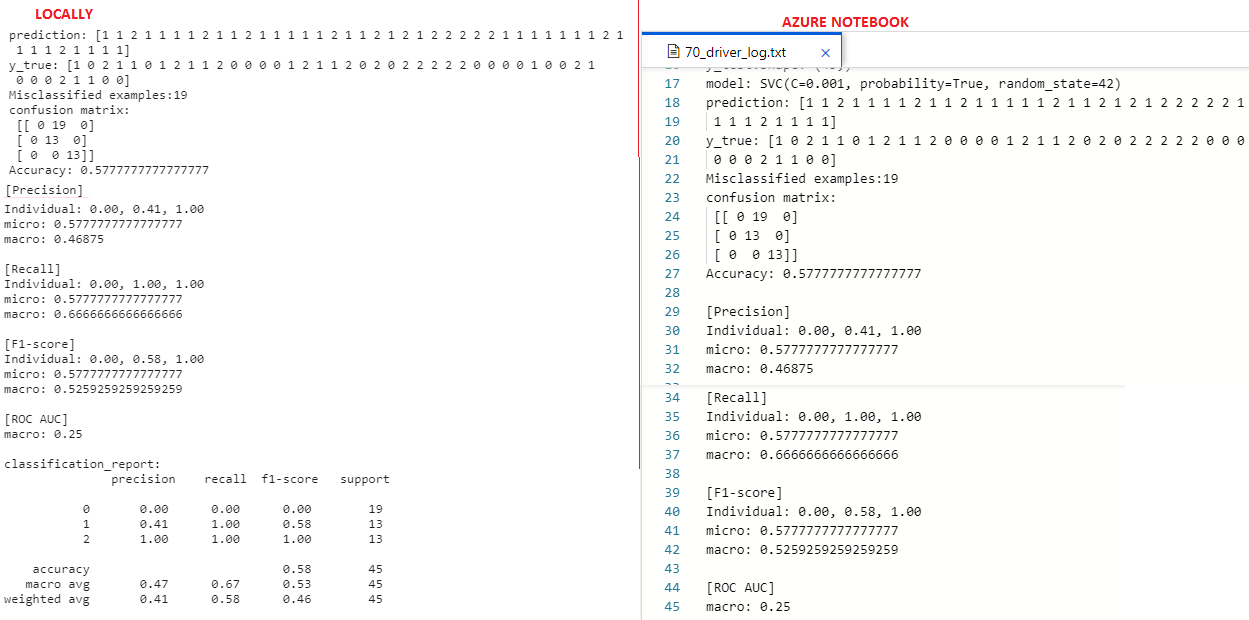

In [4]:
from IPython.display import Image
Image(filename='images/Azure/Exp-1/SVC/result.png')

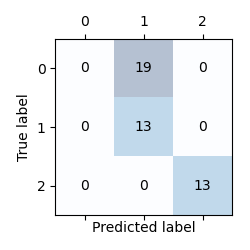

In [5]:
Image(filename='images/Azure/Exp-1/SVC/conf_mat.png')

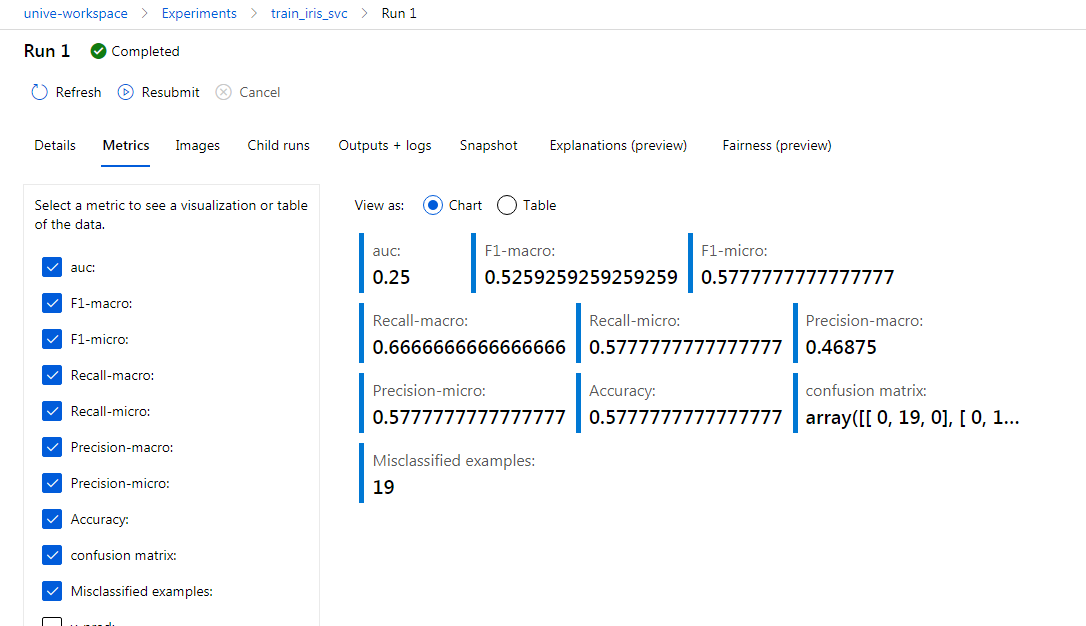

In [6]:
Image(filename='images/Azure/Exp-1/SVC/metrics.png')

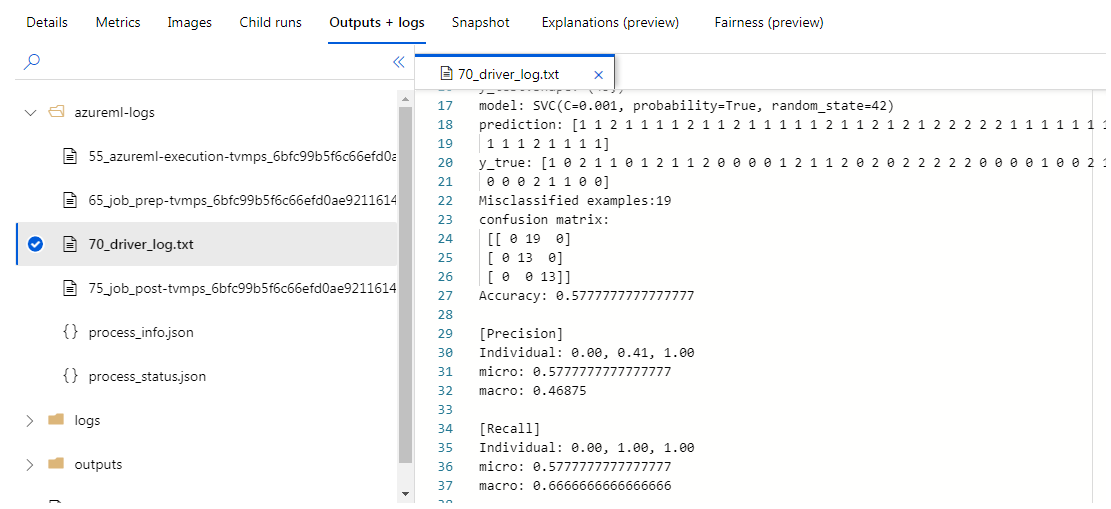

In [7]:
Image(filename='images/Azure/Exp-1/SVC/driver_log.png')
# sklearn.version:0.23.2

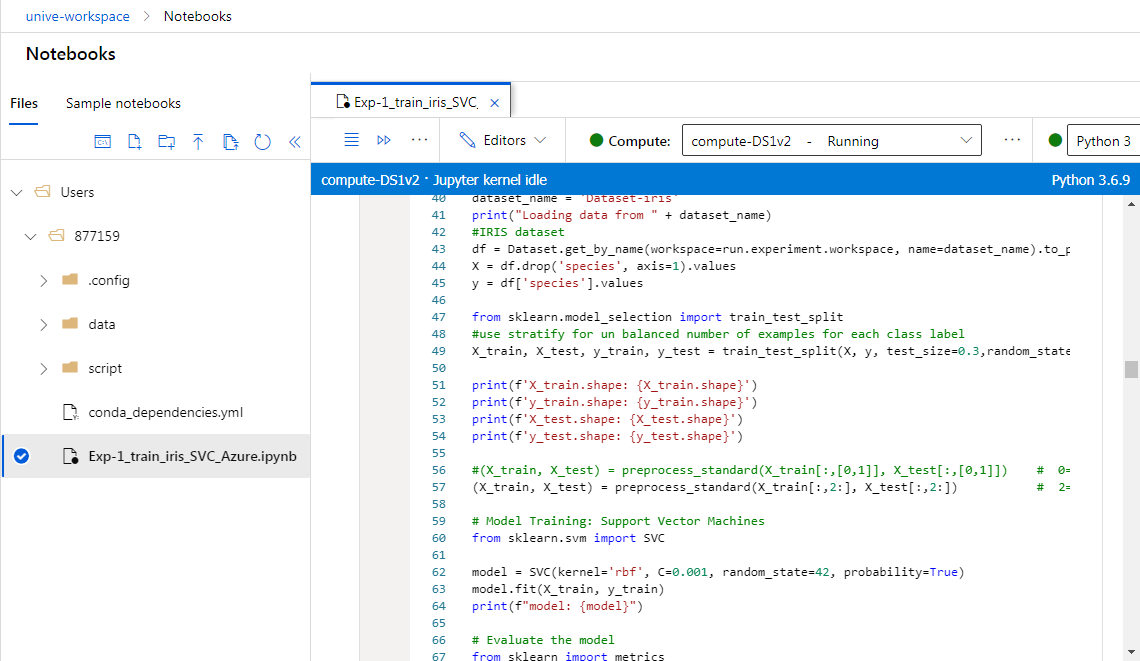

In [8]:
Image(filename='images/Azure/Exp-1/SVC/Notebook.png')

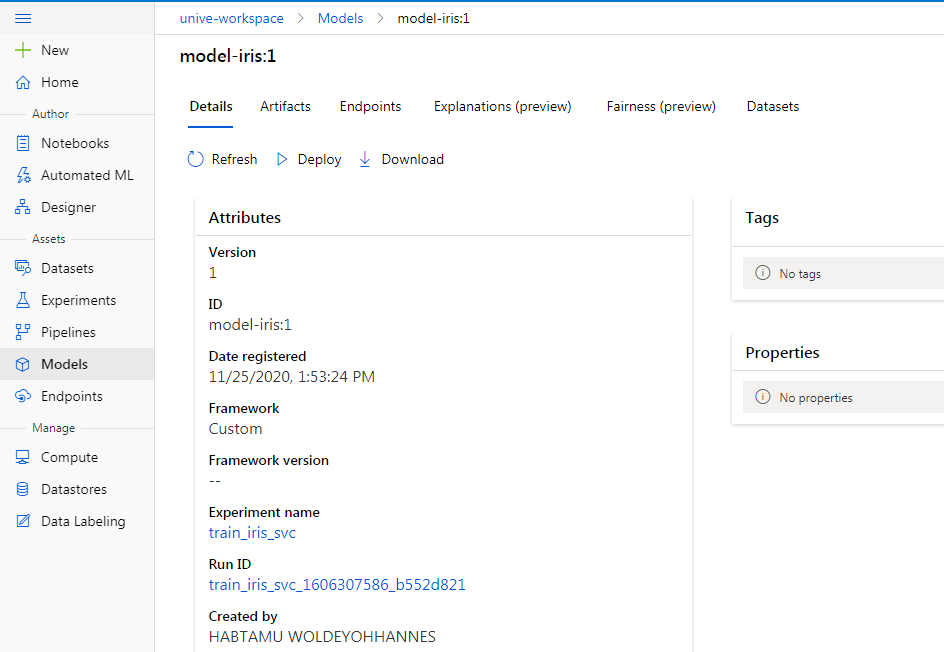

In [9]:
Image(filename='images/Azure/Exp-1/SVC/Model-1.png')

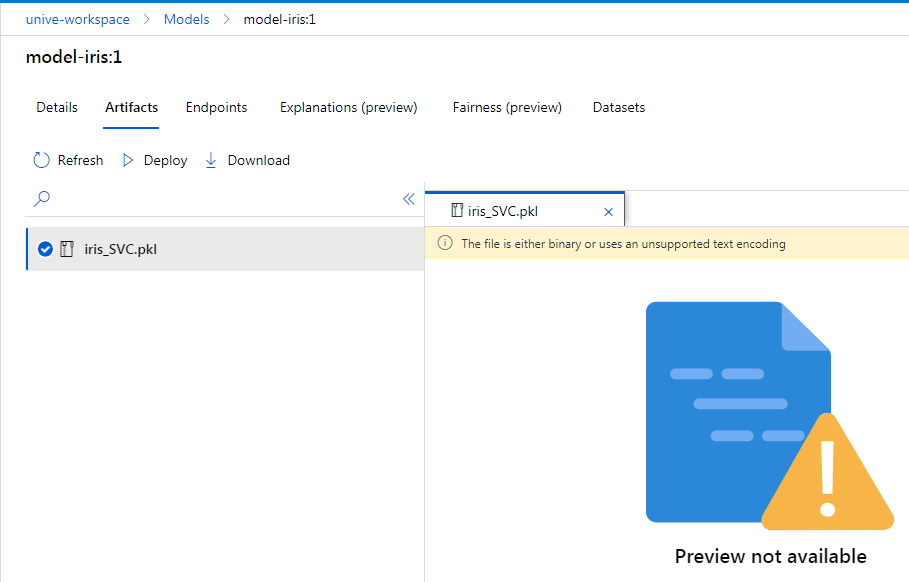

In [10]:
Image(filename='images/Azure/Exp-1/SVC/Model-download.png')

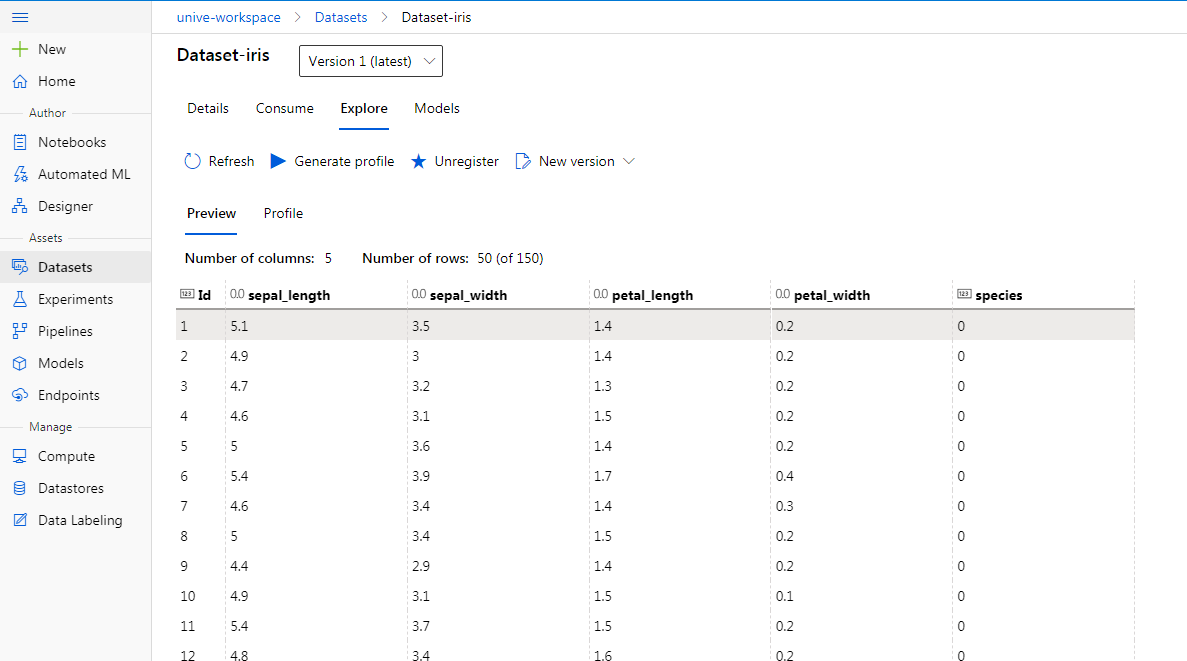

In [11]:
Image(filename='images/Azure/Exp-1/SVC/dataset.png')

## Designer

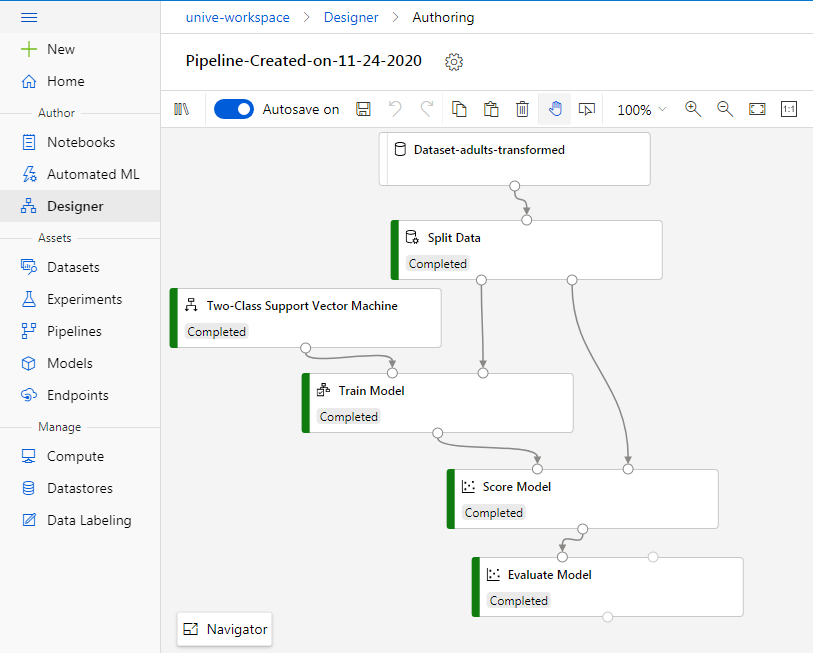

In [11]:
from IPython.display import Image
Image(filename='images/Azure/Exp-1/SVC/0-pipeline.png')

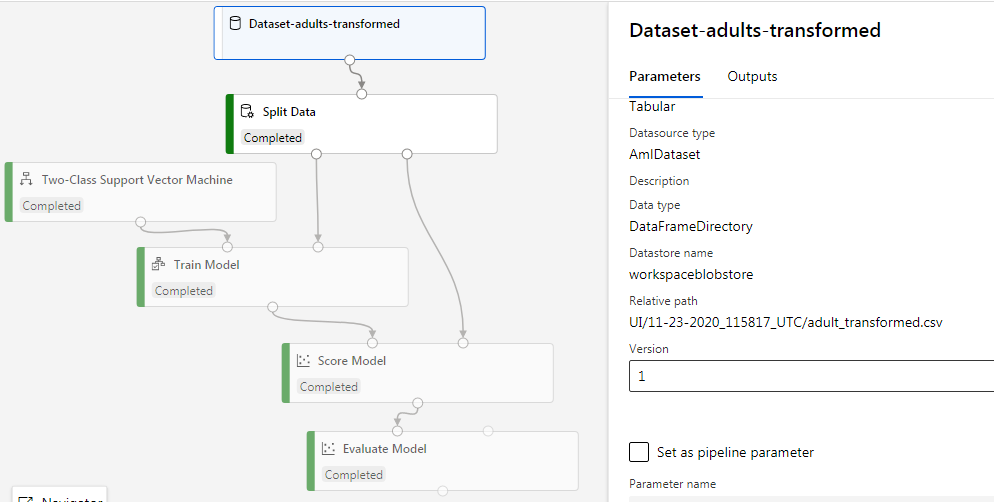

In [12]:
Image(filename='images/Azure/Exp-1/SVC/1-dataset.png')

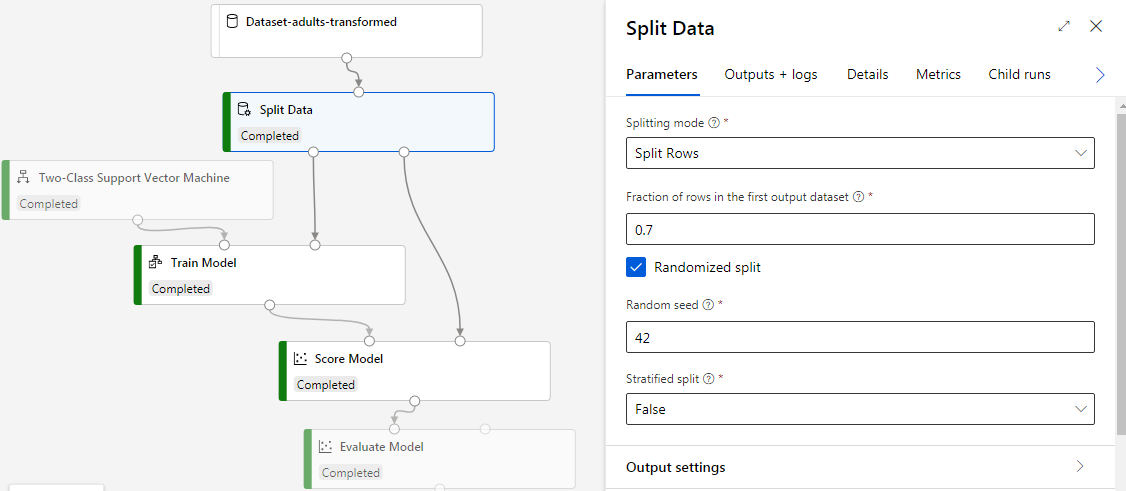

In [13]:
Image(filename='images/Azure/Exp-1/SVC/2-split.png')

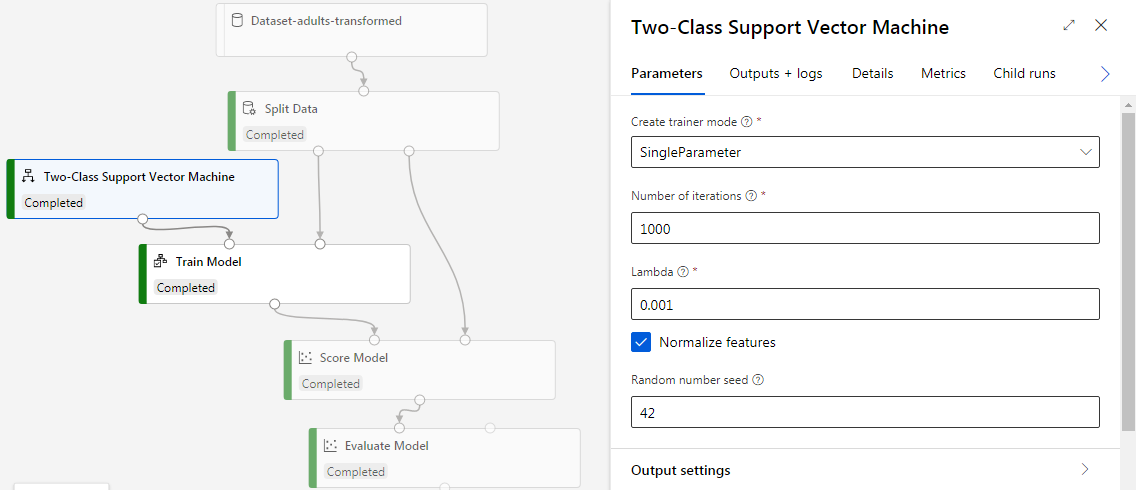

In [14]:
Image(filename='images/Azure/Exp-1/SVC/3-classify.png')

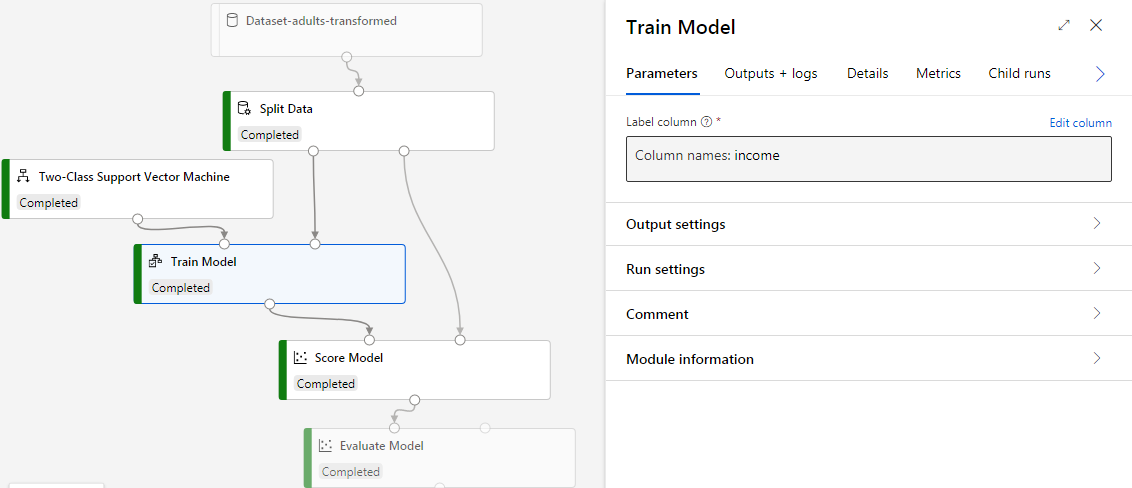

In [15]:
Image(filename='images/Azure/Exp-1/SVC/4-train-model.png')

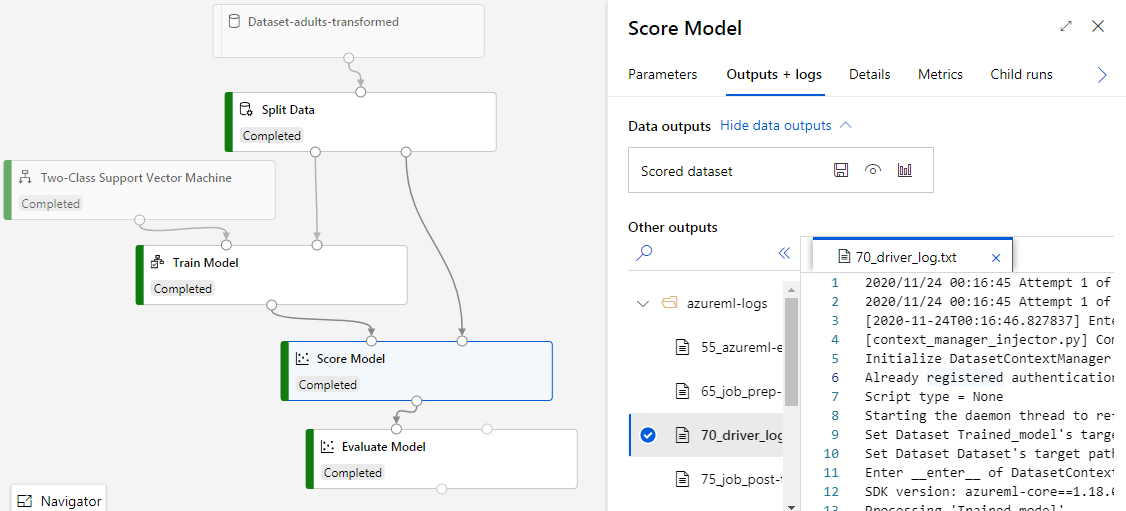

In [16]:
Image(filename='images/Azure/Exp-1/SVC/5-score-model.png')

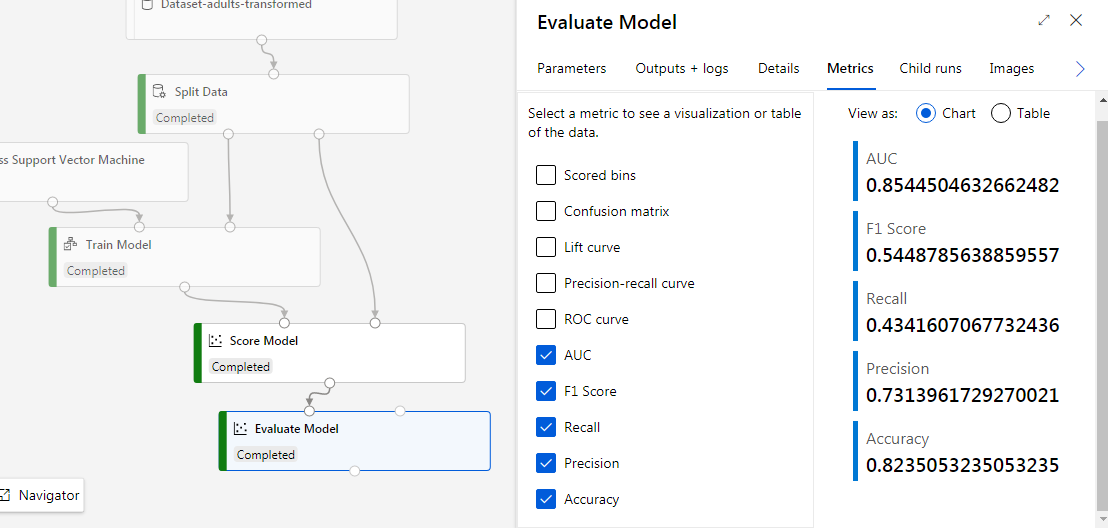

In [17]:
Image(filename='images/Azure/Exp-1/SVC/6-evaluate-model.png')

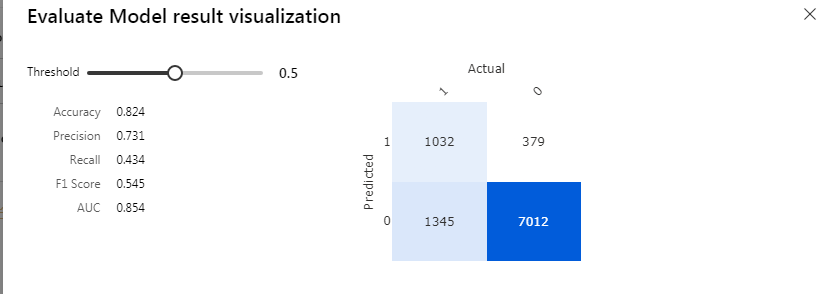

In [18]:
Image(filename='images/Azure/Exp-1/SVC/designer-metrics.png')

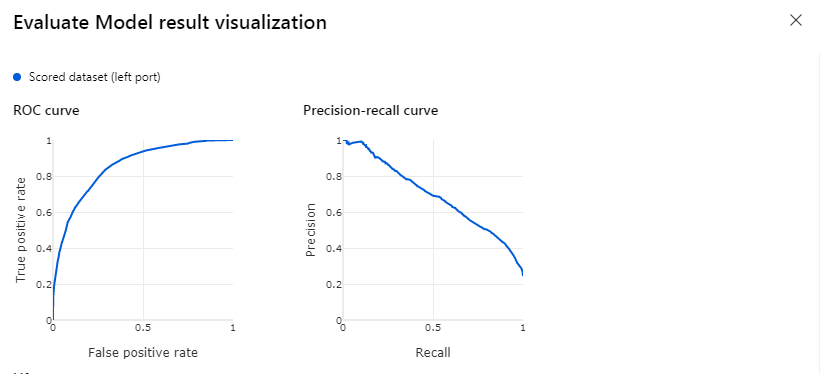

In [19]:
Image(filename='images/Azure/Exp-1/SVC/designer-metrics-2.png')

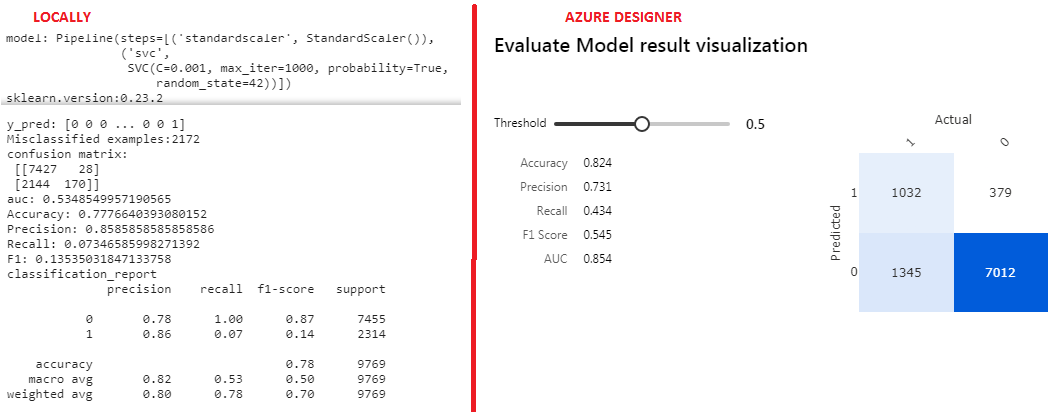

In [20]:
Image(filename='images/Azure/Exp-1/SVC/result2.png')